In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from tqdm import tqdm
import emcee
import corner
import pymultinest
import json
import getdist
from getdist import plots, MCSamples

Create the 4-d u-function as mentioned:

In [2]:
def sigmoid(x, a, b, c, d):
    """
    Returns the sigmoid function f(x) = a/(1 + e^(-(bx - c))) + d 
    
    Parameters are:
    
    a adjusts the minimum and maximum asymptotes of the sigmoidal curve
    b adjusts the steepness of the sigmoidal curve
    c shifts the curve left and right
    d shifts the curve up and down
    
    """
    return a/(1 + np.exp(-(b * x - c))) + d

def neg_exponential(x, a, b, c, d):
    """
    Returns the negative exponential function f(x) = a * e^-bx + c
    
    Parameters are:
    
    a shifts the curve left and right
    b adjusts the steepness of the curve
    c is the horizontal asymptote
    d shifts the curve left and right
    
    """
    return a * np.exp(-b * (x + d)) + c
    

def get_3d_log_likelihood(omega_a, omega_d, m_a, 
                          a_a, b_a, c_a, d_a, 
                          a_d, b_d, c_d, d_d, 
                          a_sa, b_sa, c_sa, d_sa, 
                          a_sd, b_sd, c_sd, d_sd, 
                          a_theta, b_theta, c_theta, d_theta):
    """
    Gets the 3d log likelihood for either de or dm with the given parameters for the means in the 
    omega_a and omega_de/dm direction, the variance in the omega_a direction, and the parameters for the rotation by an angle theta
    """
    
    # x vector
    x = np.array([omega_a, omega_d])  # x = [omega_a, omega_de/dm] vector
    
    # means in the mu_a and mu_de direction
    # sigmoid curves mu_a(m_a) and mu_de(m_a)
    mu_a = sigmoid(m_a, a_a, b_a, c_a, d_a)  # mu_a = mu_a(m_a)
    mu_d = sigmoid(m_a, a_d, b_d, c_d, d_d)  # mu_d = mu_d(m_a) but the sigmoidal curve has different parameters
    # mu is a vector of the two
    mu = np.array([mu_a, mu_d])  # mu = [mu_a, mu_d] vector
    
    # covariance matrix C
    sigma_a = neg_exponential(m_a, a_sa, b_sa, c_sa, d_sa)  # variance in a direction: negative exponential curve, sigma_a = sigma_a(m_a)
    sigma_d = neg_exponential(m_a, a_sd, b_sd, c_sd, d_sd) # variance in de direction: sigmoid curve, sigma_de = sigma_de(m_a)
 
    # rotation
    theta = sigmoid(m_a, a_theta, b_theta, c_theta, d_theta)
    # covariance matrix
    C = np.array(([sigma_a, 0], 
                  [0, sigma_d]))
    # rotation matrix
    rot = np.array(([np.cos(theta), -np.sin(theta)], 
                    [np.sin(theta), np.cos(theta)]))
    
    # return 2d gaussian value, applying the appropriate rotation
    f = np.exp(-((x - mu).T @ np.linalg.inv(rot @ C @ rot.T) @ (x - mu)))  # general expression for a 2D Gaussian

    return f

def get_1d_gaussian(omega_d, m_a, 
                    a_d, b_d, c_d, d_d, 
                    a_sd, b_sd, c_sd, d_sd):
    """
    Gets the 1d gaussian of omega_de or omega_dm evaluated at a given m_a (to multiply with the 3d function)
    """
    # compute 1d gaussian 
    mu_d = sigmoid(m_a, a_d, b_d, c_d, d_d)  # compute mu_d and sigma_d except with the other (de/dm) parameters not used for the 3d likelihood
    sigma_d = neg_exponential(m_a, a_sd, b_sd, c_sd, d_sd)
    # general form of 1d gaussian for a given mu and sigma
    f = np.exp(-((omega_d - mu_d) ** 2)/sigma_d)
    
    return f


def log_likelihood(omega_a, omega_de, omega_dm, m_a):
    # finally, return the log to make it log-likelihood
    return np.log(likelihood(omega_a, omega_de, omega_dm, m_a))

    
def likelihood(omega_a, omega_de, omega_dm, m_a, 
                   a_a_de=0., b_a_de=1.5, c_a_de=6., d_a_de=0., 
                   a_a_dm=0., b_a_dm=1.5, c_a_dm=6., d_a_dm=0.,
                   a_de=0., b_de=1.5, c_de=6., d_de=9.,
                   a_dm=0., b_dm=1.5, c_dm=6., d_dm=9.,
                   a_sa_de=10000., b_sa_de=2., c_sa_de=1.5, d_sa_de=0,
                   a_sa_dm=10000., b_sa_dm=-2, c_sa_dm=1.5, d_sa_dm=-20,
                   a_sde=0., b_sde=0., c_sde=0.2, d_sde=0, 
                   a_sdm=0., b_sdm=0., c_sdm=0.2, d_sdm=0, 
                   a_theta_de=np.pi/4, b_theta_de=1.5, c_theta_de=6., d_theta_de=-np.pi/4, 
                   a_theta_dm=-np.pi/4, b_theta_dm=1.5, c_theta_dm=24., d_theta_dm=0.):

    # omega_a, omega_de, omega_dm, m_a = params  # x is omega_a, y is omega_de, z is omega_dm, w is m_a
    
    # low m_a means that omega_a varies with omega_de and constant with omega_dm
    # this is DE dominates
    if m_a < 10:
        # compute the 3d log likelihood in the omega_a - omega_de plane, using the given parameters
        f_3d = get_3d_log_likelihood(omega_a, omega_de, m_a, 
                                  a_a_de, b_a_de, c_a_de, d_a_de, 
                                  a_de, b_de, c_de, d_de, 
                                  a_sa_de, b_sa_de, c_sa_de, d_sa_de, 
                                  a_sde, b_sde, c_sde, d_sde, 
                                  a_theta_de, b_theta_de, c_theta_de, d_theta_de)
        # compute the 1d gaussian in the omega_a - omega_dm plane, using those parameters
        f_1d = get_1d_gaussian(omega_dm, m_a, 
                               a_dm, b_dm, c_dm, d_dm, 
                               a_sdm, b_sdm, c_sdm, d_sdm)
        
    # high m_a means that omega_a constant with omega_de and varies with omega_dm
    # this is DM dominates
    elif m_a >= 10:
        # compute the 3d log likelihood in the omega_a - omega_dm plane, using the given parameters 
        f_3d = get_3d_log_likelihood(omega_a, omega_dm, m_a, 
                                  a_a_dm, b_a_dm, c_a_dm, d_a_dm, 
                                  a_dm, b_dm, c_dm, d_dm, 
                                  a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm, 
                                  a_sdm, b_sdm, c_sdm, d_sdm, 
                                  a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm)
        # compute the 1d gaussian in the omega_a - omega_de plane, using those parameters
        f_1d = get_1d_gaussian(omega_de, m_a, 
                               a_de, b_de, c_de, d_de, a_sde, 
                               b_sde, c_sde, d_sde)
    
    # multiply the gaussian with our original 1d gaussian to get the full likelihood
    # compute the 1d gaussian in the omega_a - omega_de plane, using those param
    return f_3d * f_1d
    
#     f_3d = get_3d_log_likelihood(omega_a, omega_dm, m_a, 
#                           a_a_dm, b_a_dm, c_a_dm, d_a_dm, 
#                           a_dm, b_dm, c_dm, d_dm, 
#                           a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm, 
#                           a_sdm, b_sdm, c_sdm, d_sdm, 
#                           a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm)
#     # compute the 1d gaussian in the omega_a - omega_de plane, using those param
#     return f_3d # * f_1d


Plot all the curves to make sure the function behaviour is working as intended:

In [3]:
# MEANS
# means in the a axis for the DE and DM functions
a_a_de, b_a_de, c_a_de, d_a_de = 0., 1.5, 6., 0. 
a_a_dm, b_a_dm, c_a_dm, d_a_dm = 0., 1.5, 6., 0.
# means in the de/dm axes for the DE and DM functions
a_de, b_de, c_de, d_de = 0., 1.5, 6., 9. 
a_dm, b_dm, c_dm, d_dm = 0., 1.5, 6., 9.

# VARIANCES
# variances in the a axis for the DE and DM functions
a_sa_de, b_sa_de, c_sa_de, d_sa_de = 10000., 2., 1.5, 0.
a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm = 10000., -2., 1.5, -20.
# variances in the de/dm axes for the DE and DM functions
a_sde, b_sde, c_sde, d_sde = 0., 0., 0.2, 0.
a_sdm, b_sdm, c_sdm, d_sdm = 0., 0., 0.2, 0.

# ROTATIONS
# rotation angles in the a-de and a-dm planes for the DE and DM functions
a_theta_de, b_theta_de, c_theta_de, d_theta_de = np.pi/4, 1.5, 6., -np.pi/4
a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm = -np.pi/4, 1.5, 24., 0.

Plot how the means `mu_a`, `mu_de` and `mu_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

They should appear constant at $\mu_a = 0$ and $\mu_{DE} = \mu_{DM} = 9$.

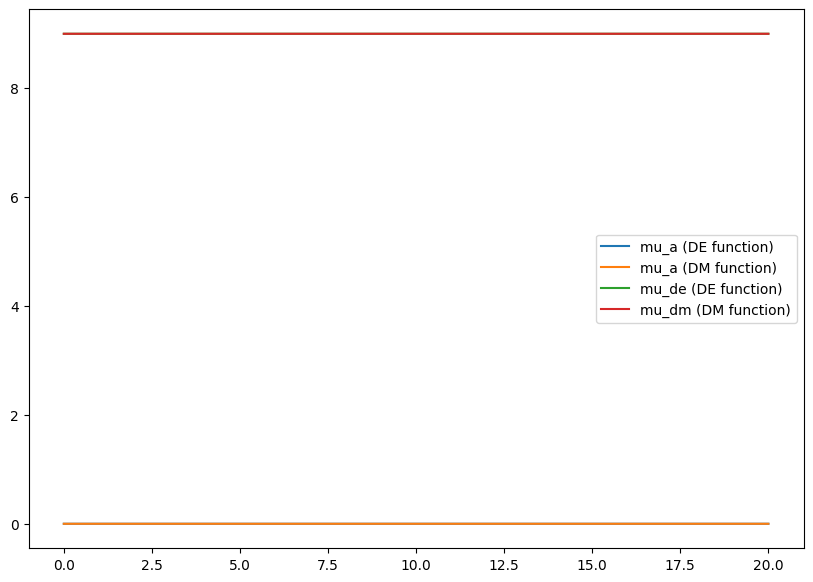

In [4]:
%matplotlib inline
# generate test mas
test_mas = np.linspace(0, 20, int(1e4))
# plot
plt.figure(figsize = (10, 7))
# mu_a for the DE and DM functions
plt.plot(test_mas, sigmoid(test_mas, a_a_de, b_a_de, c_a_de, d_a_de), alpha=1, label = 'mu_a (DE function)')
plt.plot(test_mas, sigmoid(test_mas, a_a_de, b_a_de, c_a_de, d_a_de), alpha=1, label = 'mu_a (DM function)')
# mu_de/mu-dm for the DE and DM functions
plt.plot(test_mas, sigmoid(test_mas, a_de, b_de, c_de, d_de), alpha = 1, label = 'mu_de (DE function)')
plt.plot(test_mas, sigmoid(test_mas, a_dm, b_dm, c_dm, d_dm), alpha = 1, label = 'mu_dm (DM function)')
# legend
plt.legend()

Plot how the variances `sigma_a`, `sigma_de` and `sigma_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

They should shrink (for the DE plot) or grow (for the DM plot) exponentially along the $a$-axis and be constant along the DE/DM axis.

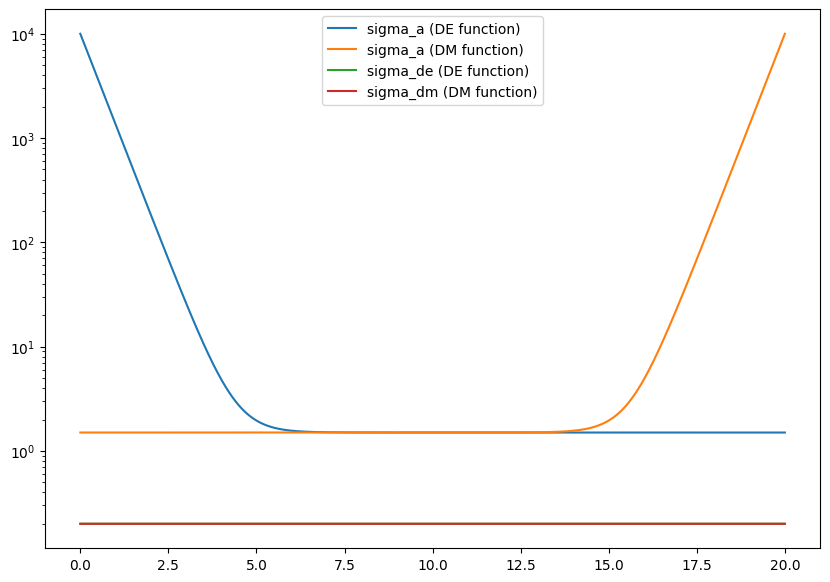

In [5]:
# plot
plt.figure(figsize = (10, 7))
# sigma_a for the DE and DM functions
plt.plot(test_mas, neg_exponential(test_mas, a_sa_de, b_sa_de, c_sa_de, d_sa_de), alpha=1, label = 'sigma_a (DE function)')
plt.plot(test_mas, neg_exponential(test_mas, a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm), alpha=1, label = 'sigma_a (DM function)')
# sigma_de/sigma_dm for the DE and DM functions
plt.plot(test_mas, neg_exponential(test_mas, a_sde, b_sde, c_sde, d_sde), alpha = 1, label = 'sigma_de (DE function)')
plt.plot(test_mas, neg_exponential(test_mas, a_sdm, b_sdm, c_sdm, d_sdm), alpha = 1, label = 'sigma_dm (DM function)')
# legend
plt.yscale('log')
plt.legend()

Plot how the rotation angles `theta_de` and `theta_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

For the DE plot, it should sigmoidally go from -$\frac{\pi}{4}$ to $0$ for $0 < m_a < 10$ and be constant at $0$ for $10 < m_a < 20$.

For the DM plot, it should be constant at $0$ for $0 < m_a < 10$ and sigmoidally go from $0$ to -$\frac{\pi}{4}$ for $10 < m_a < 20$.

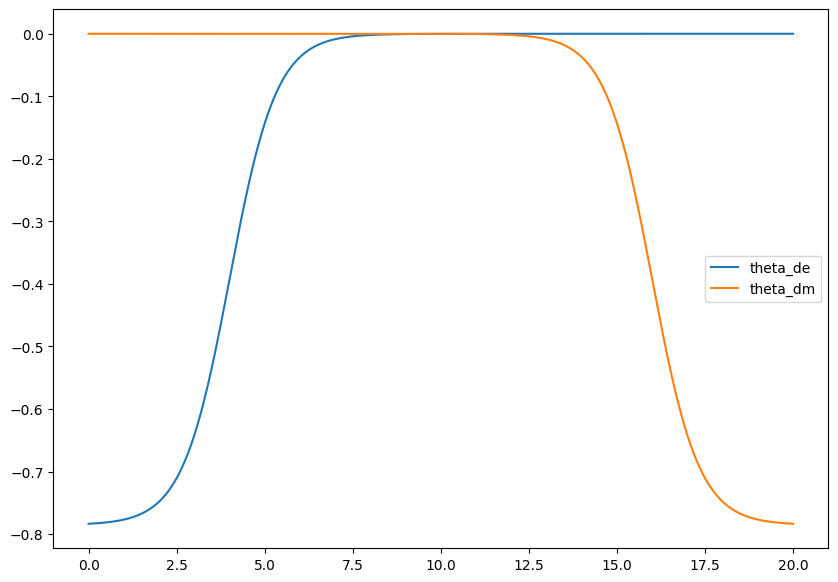

In [6]:
# plot
plt.figure(figsize = (10, 7))
# theta_de
plt.plot(test_mas, sigmoid(test_mas, a_theta_de, b_theta_de, c_theta_de, d_theta_de), alpha=1, label = 'theta_de')
# theta_dm
plt.plot(test_mas, sigmoid(test_mas, a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm), alpha=1, label = 'theta_dm')
# legend
plt.legend()

Compute the function over some $4$-D hypercube:

In [7]:
npoints = 20  # 20 or so points when I'm testing things

# bounds of our sampling
x_lower, x_upper = 0, 10  # omega_a
y_lower, y_upper = 0, 10  # omega_de
z_lower, z_upper = 0, 10  # omega_dm
w_lower, w_upper = 0, 20  # m_a

X, Y, Z, W = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
                      np.linspace(z_lower, z_upper, npoints), np.linspace(w_lower, w_upper, npoints))

# no multiprocessing

likelihood_arr = np.zeros((npoints, npoints, npoints, npoints))

for i in tqdm(range(0, len(X))):
    for j in range(0, len(Y)):
        for k in range(0, len(Z)):
            for l in range(0, len(W)):
                likelihood_arr[i, j, k, l] = likelihood(X[i, j, k, l], Y[i, j, k, l], Z[i, j, k, l], W[i, j, k, l])


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


In [8]:
from multiprocessing import Pool

npoints = 100 # 20  # 20 or so points when I'm testing things

# bounds of our sampling
x_lower, x_upper = 0, 10  # omega_a
y_lower, y_upper = 0, 10  # omega_de
z_lower, z_upper = 0, 10  # omega_dm
w_lower, w_upper = 0, 20  # m_a

X, Y, Z, W = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
                      np.linspace(z_lower, z_upper, npoints), np.linspace(w_lower, w_upper, npoints))

# # no multiprocessing

# likelihood_arr = np.zeros((npoints, npoints, npoints, npoints))

# for i in tqdm(range(0, len(X))):
#     for j in range(0, len(Y)):
#         for k in range(0, len(Z)):
#             for l in range(0, len(W)):
#                 likelihood_arr[i, j, k, l] = likelihood(X[i, j, k, l], Y[i, j, k, l], Z[i, j, k, l], W[i, j, k, l])

# mutliprocessing
                
# multiprocessing to speed this up:
with Pool() as pool:
    likelihood_arr = pool.starmap(likelihood, tqdm([(X[i, j, k, l], Y[i, j, k, l], Z[i, j, k, l], W[i, j, k, l])
                                                        for i in range(0, len(X)) 
                                                        for j in range(0, len(Y)) 
                                                        for k in range(0, len(Z)) 
                                                        for l in range(0, len(W))]))

# make likelihood_arr into an array with the proper shape
likelihood_arr = np.array(likelihood_arr).reshape(npoints, npoints, npoints, npoints)

100%|██████████| 100000000/100000000 [20:33<00:00, 81098.96it/s]


Test to make sure that meshgrid and multiprocessing are doing what I think they are:

In [9]:
testX, testY, testZ, testW = np.meshgrid(range(0, 4), range(0, 4), range(0, 4), range(0, 4))

def g(x):
    return x

with Pool() as pool:
    test2 = pool.map(g, [f'{i}, {j}, {k}, {l}' 
                  for i in np.linspace(0, 4, 4) 
                  for j in np.linspace(0, 8, 4) 
                  for k in np.linspace(0, 12, 4) 
                  for l in np.linspace(0, 16, 4)])
    
test2 = np.array(test2).reshape(4, 4, 4, 4)

Hacky fix of swapping the indices of $x$ and $y$ so $(x, y, z, w) \rightarrow (y, x, z, w)$:

In [10]:
likelihood_arr = likelihood_arr.swapaxes(0, 1)  # swaps the x and y axes in the likelihood array

Plotting behaviour in the $\Omega_a - \Omega_{DE}$ and $\Omega_a - \Omega_{DM}$ planes:

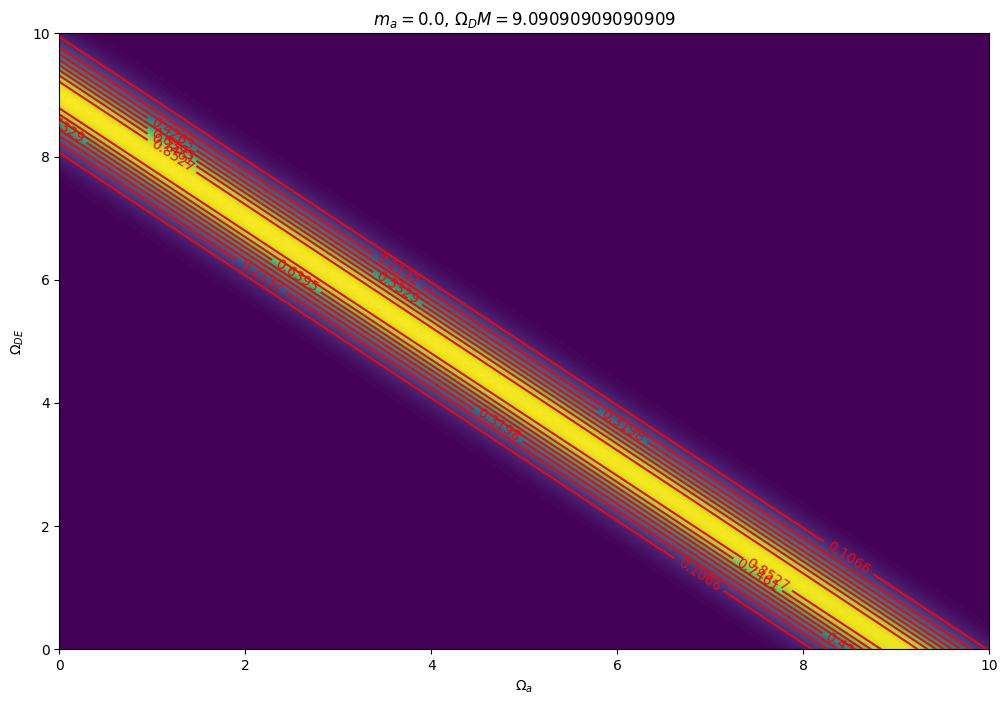

In [11]:
# plotting the omega_a - omega_de plane holding omega_dm constant

import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# ws
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_dm constant, vary m_a
omega_dm = 9 * npoints//10  # index of the omega_dm
# zs
zs = np.linspace(z_lower, z_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_dm_ind=omega_dm):
    ax.clear()
    arr = likelihood_arr[:, :, omega_dm_ind, w_ind]  # hold omega_dm constant
    # print(w_ind)
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    # print(contour_min, contour_max)
    
    # plot
    # need to transpose, I have no idea why?
    ax.contourf(X[:, :, 0, 0].T, Y[:, :, 0, 0].T, arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    ax2 = ax.contour(X[:, :, 0, 0].T, Y[:, :, 0, 0].T, arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DE}$') # x is omega_a, y is omega_de, z is m_a
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DM = ${zs[omega_dm]}') # x is omega_a, y is omega_de, z is m_a
    
ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_alternate.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

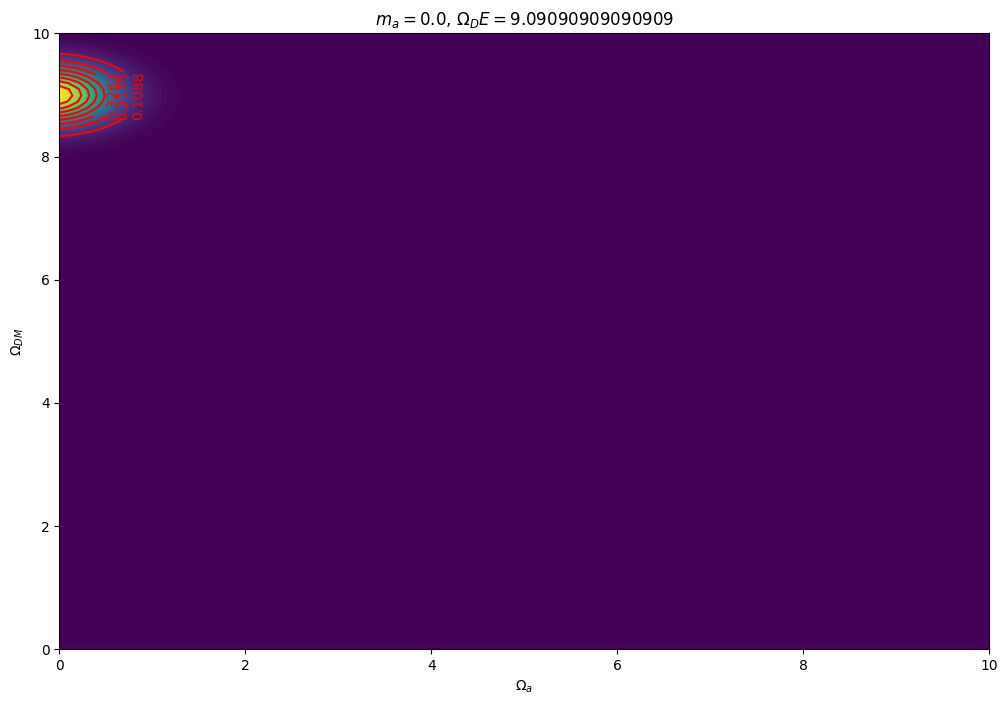

In [12]:
# plotting the omega_a  - omega_dm plane, holding omega_de constant

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# zs
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_de constant, vary m_a
omega_de = 9 * npoints//10
# ys (omega_de s)
ys = np.linspace(y_lower, y_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_de_ind=omega_de):
    ax.clear()
    arr = likelihood_arr[:, omega_de_ind, :, w_ind].T  # hold omega_de constant her einstead
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    ax.contourf(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    ax2 = ax.contour(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DM}$') # x is omega_a, y is omega_de, z is m_a
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DE = ${ys[omega_de]}') # x is omega_a, y is omega_de, z is m_a

ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_de_alternate.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

Now integrate over $\Omega_{DE}$ from $0$ to $10$ ($-\infty$ to $\infty$ should be the same...) and then $\Omega_{DM}$ from $0$ to $10$:

In [13]:
from multiprocessing import Pool
import scipy
# x is omega_a, y is omega_de, z is omega_dm, w is m_a

# scipy.integrate.dblquad integrates over the first two arguments by default, so this rearranges it
def f(omega_de, omega_dm, omega_a, m_a):
    return likelihood(omega_a, omega_de, omega_dm, m_a)


# multiprocessing to speed this up:
with Pool() as pool:
    integrated_likelihood = pool.starmap(scipy.integrate.dblquad, tqdm([(f, 0, 10, 0, 10, [X[0, i, 0, j], W[i, 0, 0, j]]) 
                                                                   for i in range(0, len(X)) 
                                                                   for j in range(0, len(W))]))
    
# make integrated likelihood into an array with the proper shape (second element is a numerical error estimate or something)
integrated_likelihood = np.array(integrated_likelihood)[:,0].reshape(npoints, npoints)

100%|██████████| 10000/10000 [04:46<00:00, 34.96it/s]  


And plot it to see if it matches the u-plot:

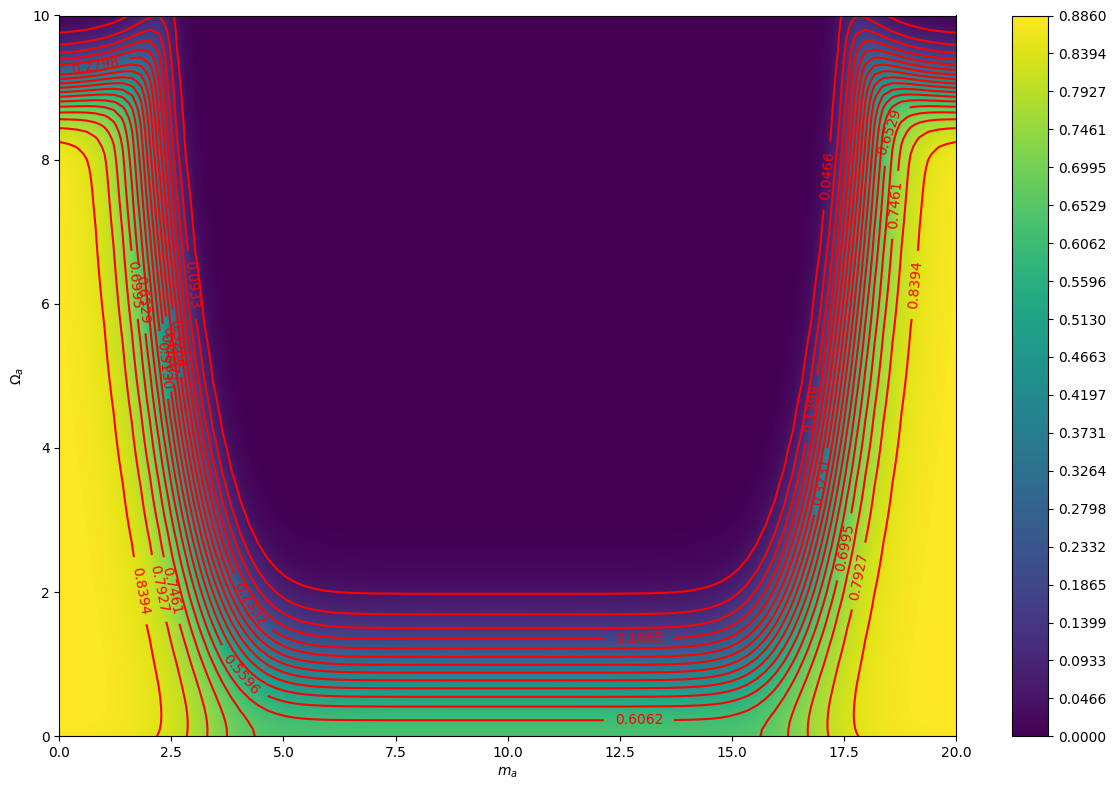

In [14]:
n_contour_points = 500

# min and max for the contours
contour_min = np.min(integrated_likelihood)
contour_max = np.max(integrated_likelihood)

integrated_omega_a, integrated_m_a = X[0, :, 0, :], W[:, 0, 0, :] # these need to be formatted in the right way

# plot
plt.figure(figsize = (12, 8))
plt.contourf(integrated_m_a, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, n_contour_points), cmap='viridis')
cb = plt.colorbar()
# cb.formatter = LogFormatterExponent(base=10)
# this goes from ~ -50 to 0
cb.set_ticks(np.linspace(contour_min, contour_max, 20))#, update_ticks=True)

plt.xlabel(r'$m_a$'), plt.ylabel(r'$\Omega_a$')

# CONTOURS
fig = plt.contour(integrated_m_a, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, 20), colors='r')
plt.clabel(fig, inline=True, fontsize=10)
plt.tight_layout()

# save
plt.savefig('integrated_4d_u_function.png')#, fmt='png')
plt.show()

## MCMC:

Define a log prior and a log probability:

In [15]:
# log prior over the 4-d distribution
def mcmc_log_prior(omega_a, omega_de, omega_dm, m_a, 
                   omega_a_min=x_lower, omega_a_max=x_upper, omega_de_min=y_lower, omega_de_max=y_upper, 
                   omega_dm_min=z_lower, omega_dm_max=z_upper, m_a_min=w_lower, m_a_max=w_upper):
    """
    Log prior that is uniform over x = (0, 10), y = (0, 10), z = (0, 10), w = (0, 20) and 0 outside of that range
    """
    # if they fall within [0, 10], [0, 10], [0, 10], [0, 20], uniform prior, otherwise 0 outside that range
    if (omega_a_min <= omega_a <= omega_a_max and omega_de_min <= omega_de <= omega_de_max 
        and omega_dm_min <= omega_dm <= omega_dm_max and m_a_min <= m_a <= m_a_max):
        return 0.  # log prior, so ln(1) = 0
    else:
        return -np.inf  # log prior, so ln(0) = -infinity
    
# log probability over the 4-d distribution
def mcmc_log_probability(params):
    omega_a, omega_de, omega_dm, m_a = params  # omega_a = x, omega_de = y, omega_dm = z, m_a = w
    # get the log prior for the params
    lp = mcmc_log_prior(omega_a, omega_de, omega_dm, m_a)
    # negative infinity (log(0)) if outside [0, 10], [0, 10], [0, 10], [0, 20] as detected by the log prior
    if not np.isfinite(lp):
        return -np.inf
    # otherwise, log prob is log prior + log likelihood
    return lp + log_likelihood(omega_a, omega_de, omega_dm, m_a) 

Now set up the MCMC (use $50$ walkers with $10^5$ steps) just to check. The starting position of our walkers is drawn from a small Gaussian distribution ($\sigma_i = 0.01$ for $i \in \{1, 2, 3, 4\}$) around the bottom left and bottom right regions of the marginal $2$-D distribution, at the likelihood maxima of $\Omega_{{DE}_{max}} = \Omega_{{DM}_{max}} = 9$

In [16]:
nwalkers = 50  # nubmer of walkers to use in the MCMC
ndim = 4  # 4 dimensions for our 4-D likelihood function
seed = 0  # seed to use for picking a random point
nsteps = int(1e5)  # number of mcmc steps to take

# choose two starting positions at the bottom left and right corners (w=1 and w=19) 
# and see if the chains are still well-mixed
left_pos = [0.2, 9, 9, 1]  # omega_a = 0.2, omega_de = omega_dm = 9, m_a = 1
right_pos = [0.2, 9, 9, 19]  # omega_a = 0.2, omega_de = omega_dm = 9, m_a = 19
np.random.seed(seed)  # set the seed

left_pos = np.random.multivariate_normal(left_pos, cov = np.diag([0.01, 0.01, 0.01, 0.01], k=0), size=nwalkers//2)
right_pos = np.random.multivariate_normal(right_pos, cov = np.diag([0.01, 0.01, 0.01, 0.01], k=0), size=nwalkers//2)
pos = np.concatenate((left_pos, right_pos))

# filename to save to/load from:
filename = '4d_u_function_mcmc_chains.h5'

And set up and run the sampler (only run this to generate chains if they don't already exist):

In [17]:
# backend = emcee.backends.HDFBackend(filename)
# backend.reset(nwalkers, ndim)

# # # running the sampler (w/ parallelization):

# # with Pool() as pool:
# #     sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_log_probability, pool = pool, backend = backend)
# #     sampler.run_mcmc(pos, nsteps, progress=True)

# # running the sampler (w/out parallelization):

# sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_log_probability, backend=backend)
# sampler.run_mcmc(pos, nsteps, progress=True)

# # Get the chain from the samples
# burnin = 200  # discard 200 burn in steps
# samples = sampler.get_chain()[burnin:]  # discard the first 200 samples ("burn-in" time for the chains to be well-mixed)

# # split into x (omega_a), y (omega_de), z (omega_dm) and w (m_a) samples

Get the samples as a chain and then plot all the 2-D marginalized plots using `corner`:

In [18]:
import h5py
cluster_data = h5py.File(filename, 'r')  # import data
burnin = 200  # discard 200 burn in steps
accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted'])[burnin:], np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

# remove burn in
samples = samples[burnin:]

In [19]:
omega_a_samples = samples[:, :, 0]
omega_de_samples = samples[:, :, 1]
omega_dm_samples = samples[:, :, 2]
m_a_samples = samples[:, :, 3]

Generate the $2$-D marginalized u-distribution ($m_a$ vs. $\Omega_a$) and compare to before:

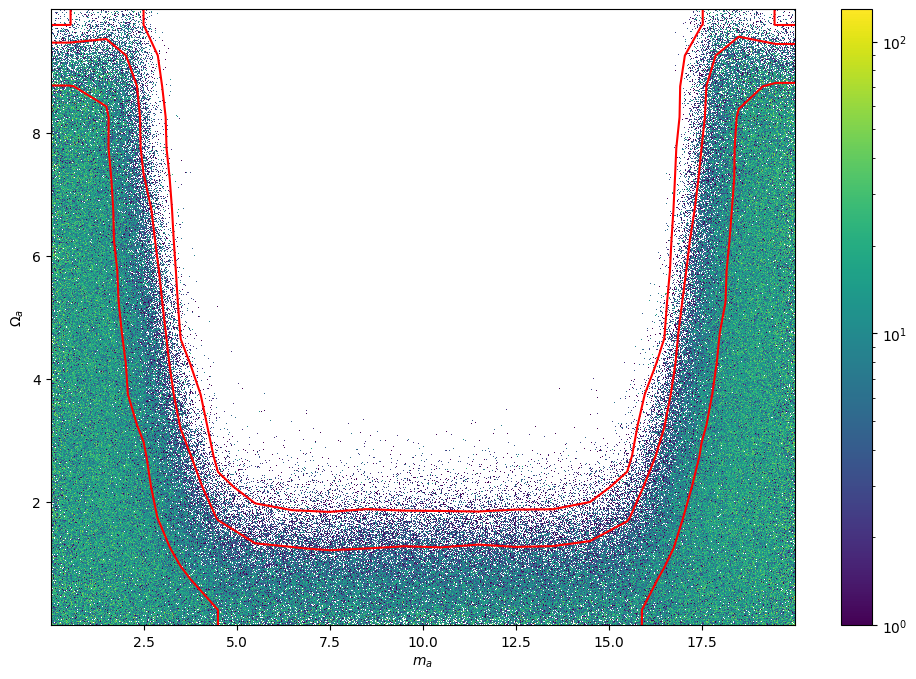

In [20]:
plt.figure(figsize = (12, 8))
# contours
corner.hist2d(m_a_samples.reshape(-1), omega_a_samples.reshape(-1), s=0.1, 
              plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r')
# density histogram
plt.hist2d(m_a_samples.reshape(-1), omega_a_samples.reshape(-1), norm = LogNorm(), bins=1000)
plt.xlabel(r'$m_a$'), plt.ylabel(r'$\Omega_a$')
cb = plt.colorbar()
plt.savefig('m_a_omega_a_mcmc.png')#, fmt='png')
plt.show()

Generate all the marginal distributions with `corner.corner`

<Figure size 1200x800 with 0 Axes>

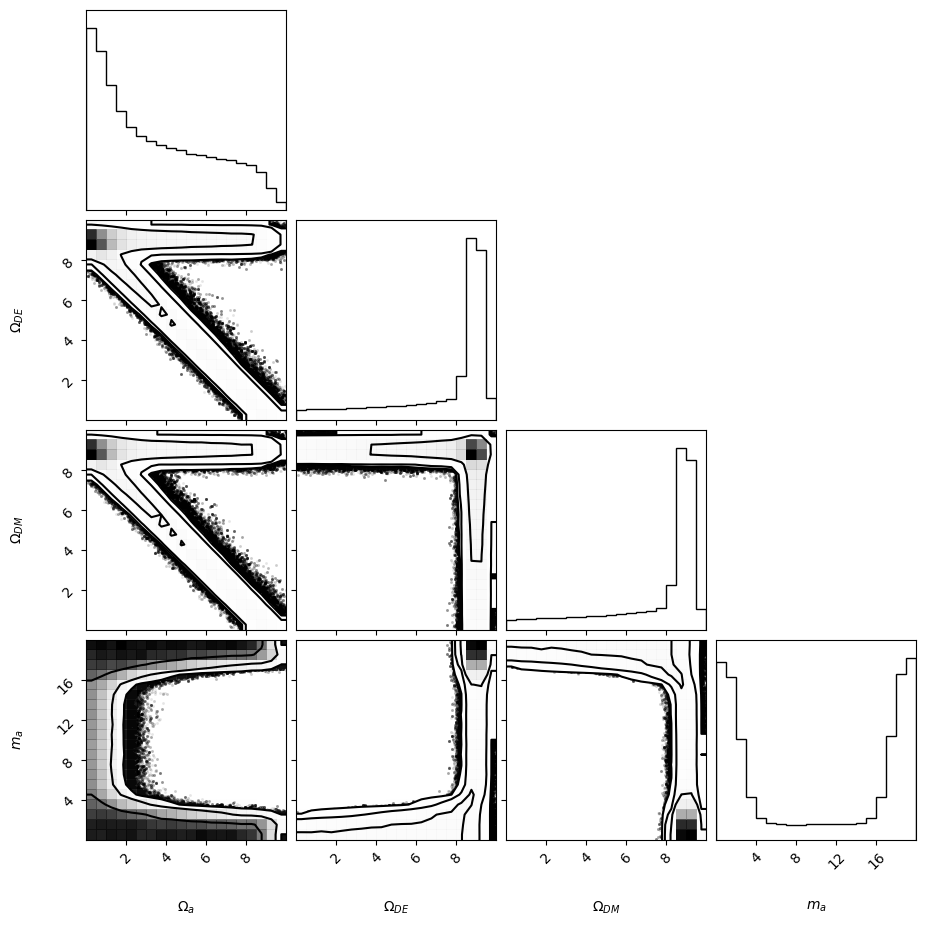

In [21]:
plt.figure(figsize = (12, 8))
corner.corner(samples.reshape(((nsteps-200) * 50, 4)), labels=[r'$\Omega_a$', r'$\Omega_{DE}$', r'$\Omega_{DM}$', r'$m_a$'], levels=[0.68, 0.95, 0.99])
plt.savefig('4d_marginalized_cornerplot_mcmc.png')#, fmt='png')
plt.show()

Plot to see if the chains are well-mixed:

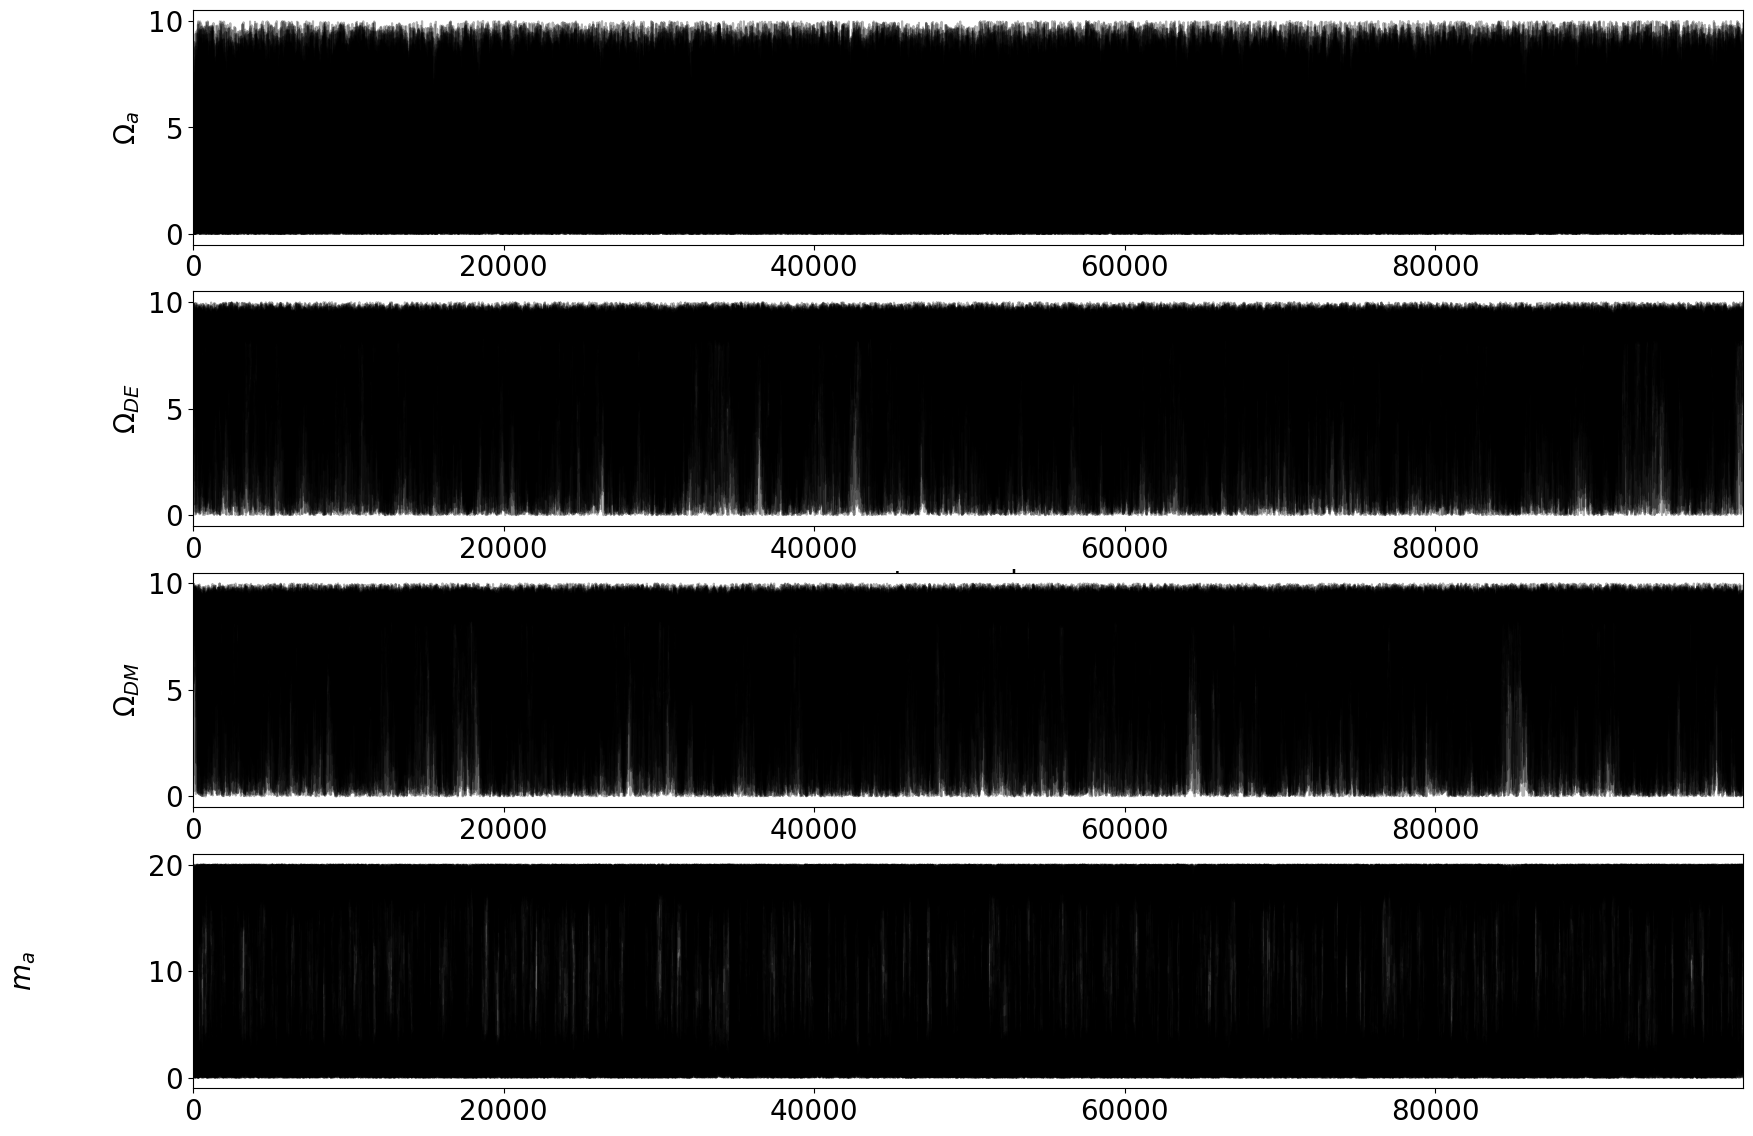

In [22]:
plt.rc('font', size=20)
_, ax = plt.subplots(4, figsize = (20, 14))
# plot the chains for x
ax[0].plot(omega_a_samples, color='k', alpha=0.3)
ax[0].set_xlim(0, len(omega_a_samples))
ax[0].set_ylabel(r'$\Omega_a$')
# plot the chains for y
ax[1].plot(omega_de_samples, color='k', alpha=0.3)
ax[1].set_xlim(0, len(omega_de_samples))
ax[1].set_ylabel(r'$\Omega_{DE}$')
# plot chains for z
ax[2].plot(omega_dm_samples, color='k', alpha=0.3)
ax[2].set_xlim(0, len(omega_dm_samples))
ax[2].set_ylabel(r'$\Omega_{DM}$')
# plot chains for w
ax[3].plot(m_a_samples, color='k', alpha=0.3)
ax[3].set_xlim(0, len(m_a_samples))
ax[3].set_ylabel(r'$m_a$')
# set shared x label
ax[1].set_xlabel('step number')
ax[3].yaxis.set_label_coords(-0.1, 0.5)
# plt.savefig('u_plot_chains.png', fmt='png')
plt.show()

## Nested sampling:

Define a nested prior using the same upper and lower bounds used for MCMC:

In [23]:
# bounds of our sampling
x_lower, x_upper = 0, 10  # omega_a
y_lower, y_upper = 0, 10  # omega_de
z_lower, z_upper = 0, 10  # omega_dm
w_lower, w_upper = 0, 20  # m_a

def nested_prior(cube, 
                 x_min=x_lower, x_max=x_upper, 
                 y_min=y_lower, y_max=y_upper, 
                 z_min=z_lower, z_max=z_upper, 
                 w_min=w_lower, w_max=w_upper):
    """
    Prior that is uniform 1 over x = (0, 10), y = (0, 10), z = (0, 10), w = (0, 20) and 0 outside of that range
    params are x, y
    
    Transforms uniform unit cube to cube defined by x and y above
    """

    # transform uniform unit cube
    cube[0] = cube[0] * (x_max - x_min) + x_min  # transforms [0, 1] unit cube to [x_min, x_max] uniform
    cube[1] = cube[1] * (y_max - y_min) + y_min  # transforms [0, 1] unit cube to [y_min, y_max] uniform
    cube[2] = cube[2] * (z_max - z_min) + z_min  # transforms [0, 1] unit cube to [z_min, z_max] uniform
    cube[3] = cube[3] * (w_max - w_min) + w_min  # transforms [0, 1] unit cube to [w_min, w_max] uniform
    
    return cube

Set up the nested sampler:

In [24]:
params = ['omega_a', 'omega_de', 'omega_dm', 'm_a']  # x, y, z, w in that order
n_params = len(params)

Run PyMultiNest (only if need to re generate the data):

In [25]:
# import pymultinest
# prefix = '4d_chains/nested-'

# # run the pymultinest, try with 1e5 points first with the same parameters are with the 2d function to see if it works

# def g(params):
#     # unpack tuple of params
#     omega_a, omega_de, omega_dm, m_a = params
#     # return log likelihood of those params
#     return log_likelihood(omega_a, omega_de, omega_dm, m_a)

# result = pymultinest.solve(LogLikelihood=g, Prior=nested_prior, n_dims=n_params, 
#                            n_live_points=int(1e5), evidence_tolerance=0.5, outputfiles_basename=prefix, verbose=True)
# # pymultinest.run()

Loading the data:

In [26]:
prefix = '4d_chains/nested-'

post_equal_weights = np.loadtxt(f'{prefix}post_equal_weights.dat')
res = np.loadtxt(f'{prefix}.txt')
# stats = np.loadtxt(f'{prefix}stats.dat')

Plotting $2$-D histogram ($m_a$ vs $\Omega_a$) of the sampled distribution:

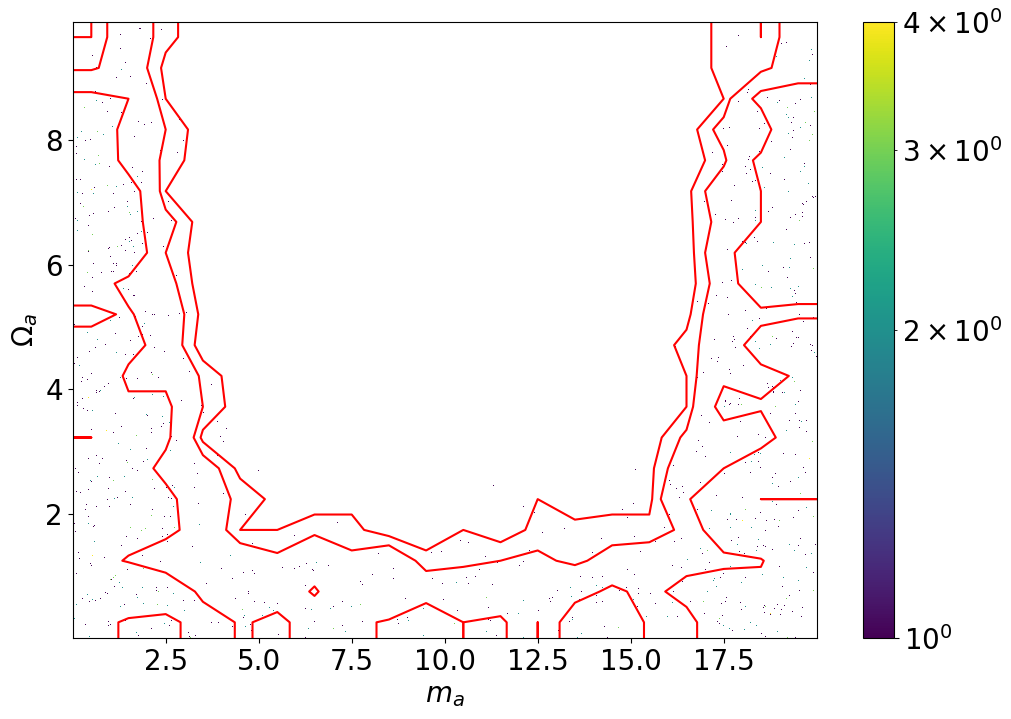

In [31]:
plt.figure(figsize = (12, 8))
# contours (parameters are omega_a, omega_de, omega_dm, m_a)
corner.hist2d(post_equal_weights[:,3], post_equal_weights[:,0], s=0.1, 
              plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r')
# density
plt.hist2d(post_equal_weights[:,3], post_equal_weights[:, 0], norm=LogNorm(), bins=1000)
plt.xlabel(r'$m_a$'), plt.ylabel(r'$\Omega_a$')
cb = plt.colorbar()
plt.savefig('m_a_omega_a_nested.png')#, fmt='png')
plt.show()

Plotting the full $4$-D marginalized cornerplot:

<Figure size 1200x800 with 0 Axes>

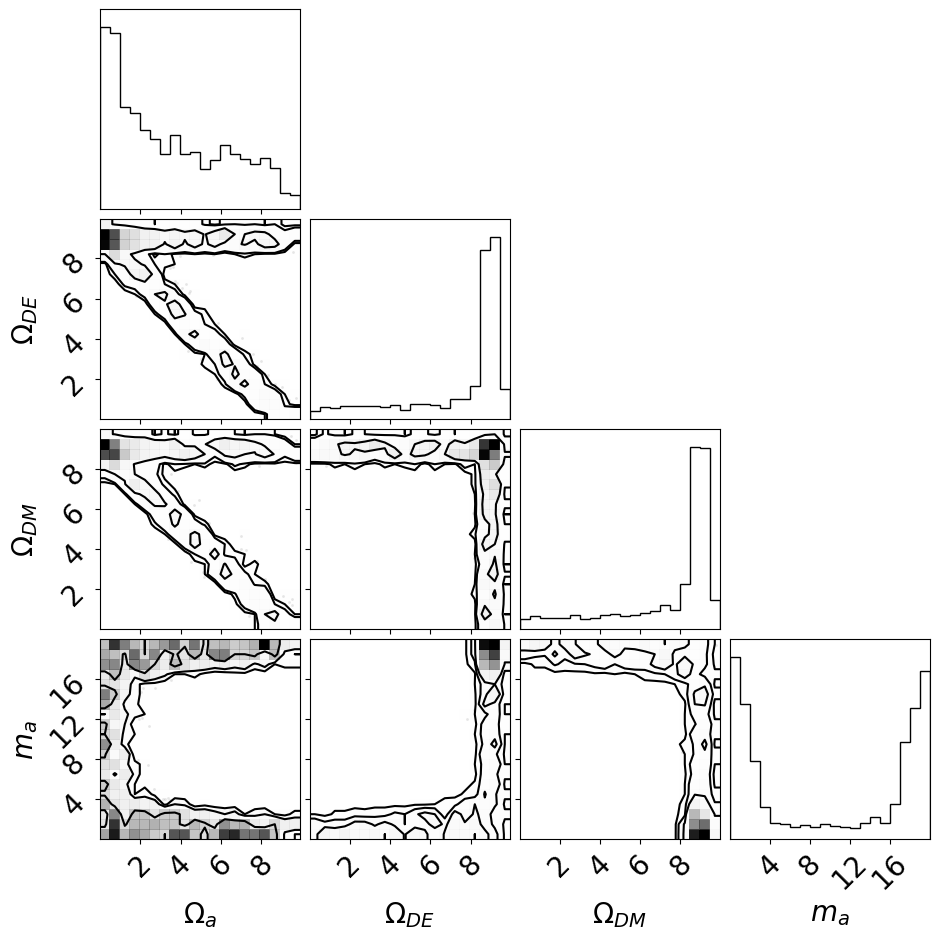

In [28]:
plt.figure(figsize = (12, 8))
corner.corner(post_equal_weights[:,:-1], labels=[r'$\Omega_a$', r'$\Omega_{DE}$', r'$\Omega_{DM}$', r'$m_a$'], 
              levels=[0.68, 0.95, 0.99])
plt.savefig('4d_marginalized_cornerplot_nested.png')#, fmt='png')
plt.show()

Removed no burn in


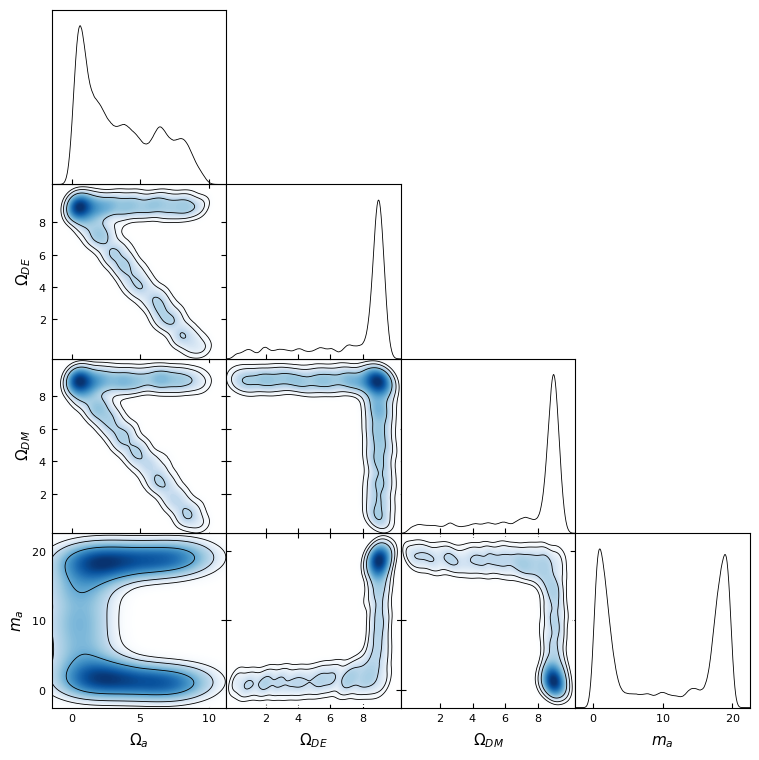

In [29]:
# converting the nested samples into an MCSamples object for plotting with getDist
# post_equal_weights[:, :-1] removes the last column (loglikes)
nested_samples = MCSamples(samples=post_equal_weights[:, :-1], names=[r'\Omega_a', r'\Omega_{DE}', r'\Omega_{DM}', r'm_a'], 
                           labels=[r'\Omega_a', r'\Omega_{DE}', r'\Omega_{DM}', r'm_a'])
# 1, 2, 3 sigma
nested_samples.updateSettings({'contours': [0.68, 0.95, 0.99]})

# plotting using getDist
g2 = plots.get_subplot_plotter()
g2.settings.num_plot_contours = 3
g2.triangle_plot(nested_samples, [r'\Omega_a', r'\Omega_{DE}', r'\Omega_{DM}', r'm_a'], shaded=True)
plt.savefig('4d_marginalized_cornerplot_nested_contours.png')#, fmt='png')
plt.show()